In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import wandb

In [51]:
wandb.login()
api = wandb.Api()
artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v3', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_big = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        break

artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v4', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_small = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        break

artifact = api.artifact('rueedi-tobias-hochschule-luzern/Own CNN/cnn-model:v5', type='model')
model_path = artifact.download()

for file in os.listdir(model_path):
    if file.endswith(".h5") or file.endswith(".keras"):
        model_general = tf.keras.models.load_model(os.path.join(model_path, file), compile=False)
        break


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact cnn-model:v3, 50.21MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0 (51.9MB/s)
wandb:   1 of 1 files downloaded.  
wandb: Downloading large artifact cnn-model:v5, 50.21MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.6 (13.9MB/s)


In [17]:
def apply_nms(pred_grid, conf_thresh=0.3, iou_thresh=0.4):
    boxes = []
    scores = []

    for gy in range(20):
        for gx in range(20):
            for b in range(3):
                pred = pred_grid[gy, gx, b]
                conf = pred[4]
                if conf < conf_thresh:
                    continue

                x, y, w, h = pred[:4]
                cx = (gx + x) / 20
                cy = (gy + y) / 20
                xmin = cx - w / 2
                ymin = cy - h / 2
                xmax = cx + w / 2
                ymax = cy + h / 2

                boxes.append([ymin, xmin, ymax, xmax])
                scores.append(conf)

    if not boxes:
        return [], []

    boxes = tf.constant(boxes, dtype=tf.float32)
    scores = tf.constant(scores, dtype=tf.float32)

    selected_indices = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=10,
        iou_threshold=iou_thresh,
        score_threshold=conf_thresh
    )

    selected_boxes = tf.gather(boxes, selected_indices).numpy()
    selected_scores = tf.gather(scores, selected_indices).numpy()

    return selected_boxes, selected_scores



In [18]:
def load_images_from_folder(folder_path, num_images=None, target_size=(640, 640)):
    image_paths = [os.path.join(folder_path, f)
                   for f in os.listdir(folder_path)
                   if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_paths = sorted(image_paths)

    if num_images:
        image_paths = image_paths[:num_images]

    images = []
    originals = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        originals.append(img.copy())
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized) / 255.0
        images.append(img_array)

    print(f"📂 Loaded {len(images)} image(s) from: {folder_path}")
    return np.array(images), originals, image_paths


In [19]:
def visualize_predictions(model, image_batch, original_images, image_paths, target_size=(640, 640)):
    for i in range(len(image_batch)):
        input_tensor = np.expand_dims(image_batch[i], axis=0)
        pred = model.predict(input_tensor)[0]  # shape: (grid_y, grid_x, B, 6)
        nms_boxes, scores = apply_nms(pred)

        image = original_images[i]
        draw = ImageDraw.Draw(image)
        font = ImageFont.truetype("arial.ttf", 20)
        w, h = image.size

        for box in nms_boxes:
            ymin, xmin, ymax, xmax = box
            x1, y1 = int(xmin * w), int(ymin * h)
            x2, y2 = int(xmax * w), int(ymax * h)
            draw.rectangle([x1, y1, x2, y2], outline="red", width=10)
            draw.text((x1 + 4, y1 - 10), "Pred", fill="red", font=font)

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Predictions for: {os.path.basename(image_paths[i])}")
        plt.axis("off")
        plt.show()


In [25]:
def visualize_two_models_on_image(model1, model2, image_array, original_image, image_name,
                                  color1="red", label1="Model 1",
                                  color2="blue", label2="Model 2"):
    # Predict
    pred1 = model1.predict(np.expand_dims(image_array, axis=0))[0]
    pred2 = model2.predict(np.expand_dims(image_array, axis=0))[0]

    # NMS
    boxes1, _ = apply_nms(pred1)
    boxes2, _ = apply_nms(pred2)

    # Draw
    draw = ImageDraw.Draw(original_image)
    font = ImageFont.truetype("arial.ttf", 20)
    w, h = original_image.size

    for box in boxes1:
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        draw.rectangle([x1, y1, x2, y2], outline=color1, width=10)
        draw.text((x1 + 4, y1 - 10), label1, fill=color1, font=font)

    for box in boxes2:
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        draw.rectangle([x1, y1, x2, y2], outline=color2, width=10)
        draw.text((x1 + 4, y2 + 5), label2, fill=color2, font=font)

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.title(f"Overlayed Predictions on: {image_name}")
    plt.axis("off")
    plt.show()


In [50]:
def visualize_ensemble_prediction(model1, model2, model3, image_array, original_image, image_name,
                                  conf_thresh=0.3, iou_thresh=0.5,
                                  weight1=0.5, weight2=0.5, weight3=0.5):
    # Predict with both models
    pred1 = model1.predict(np.expand_dims(image_array, axis=0))[0]
    pred2 = model2.predict(np.expand_dims(image_array, axis=0))[0]
    pred3 = model3.predict(np.expand_dims(image_array, axis=0))[0]

    # Apply NMS independently
    boxes1, scores1 = apply_nms(pred1, conf_thresh, iou_thresh)
    boxes2, scores2 = apply_nms(pred2, conf_thresh, iou_thresh)
    boxes3, scores3 = apply_nms(pred2, conf_thresh, iou_thresh)

    # Combine predictions
    all_boxes = np.concatenate([boxes1, boxes2, boxes3], axis=0)
    all_scores = np.concatenate([weight1 * np.array(scores1), weight2 * np.array(scores2), weight3 * np.array(scores3)], axis=0)

    # Final NMS on combined predictions
    if len(all_boxes) == 0:
        final_boxes = []
    else:
        indices = tf.image.non_max_suppression(
            boxes=tf.constant(all_boxes, dtype=tf.float32),
            scores=tf.constant(all_scores, dtype=tf.float32),
            max_output_size=20,
            iou_threshold=iou_thresh,
            score_threshold=conf_thresh
        )
        final_boxes = tf.gather(all_boxes, indices).numpy()

    # Draw on image
    draw = ImageDraw.Draw(original_image)
    font = ImageFont.truetype("arial.ttf", 20)
    w, h = original_image.size

    for box in final_boxes:
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)
        draw.rectangle([x1, y1, x2, y2], outline="purple", width=10)
        draw.text((x1 + 4, y1 - 10), "Ensemble", fill="purple", font=font)

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.title(f"Ensemble Prediction: {image_name}")
    plt.axis("off")
    plt.show()


In [34]:
def visualize_feature_maps(model, image_array, layer_name="conv2d_5", num_maps=8):
    """
    Visualize intermediate feature maps of a YOLO-style model.
    
    Parameters:
    - model: trained Keras model
    - image_array: preprocessed input image (H, W, 3)
    - layer_name: name of the convolutional layer to inspect
    - num_maps: number of feature maps to visualize
    """
    intermediate_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.get_layer(layer_name).output)

    feature_maps = intermediate_model.predict(np.expand_dims(image_array, axis=0))  # shape: (1, H, W, C)

    print(f"Feature maps shape: {feature_maps.shape}")

    for i in range(min(num_maps, feature_maps.shape[-1])):
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.title(f"Feature map {i} from '{layer_name}'")
        plt.axis('off')
        plt.show()

In [35]:
def log_prediction_to_wandb(image_pil, boxes, image_name="Image"):
    """
    Logs an image with predicted bounding boxes to WandB.
    
    Parameters:
    - image_pil: original PIL image
    - boxes: list of [ymin, xmin, ymax, xmax] in relative coords (0–1)
    - image_name: name or ID for the image
    """
    width, height = image_pil.size
    box_data = {
        "predictions": {
            "box_data": [
                {
                    "position": {
                        "minX": int(xmin * width),
                        "maxX": int(xmax * width),
                        "minY": int(ymin * height),
                        "maxY": int(ymax * height)
                    },
                    "class_id": 0,
                    "box_caption": "Detected",
                    "scores": {"confidence": 1.0}
                } for ymin, xmin, ymax, xmax in boxes
            ],
            "class_labels": {0: "Disease"}
        }
    }

    wandb.log({
        "predicted_image": wandb.Image(image_pil, boxes=box_data, caption=image_name)
    })

In [39]:
from PIL import Image
import matplotlib.cm as cm

def overlay_feature_map_on_image(image_array, feature_map, alpha=0.5, cmap='jet'):
    """
    Overlay a feature map (H x W) on the original image (H x W x 3).
    
    Parameters:
    - image_array: original image as NumPy array (H, W, 3), values 0–1
    - feature_map: feature map as NumPy array (h, w)
    - alpha: transparency factor for overlay (0–1)
    - cmap: matplotlib colormap to apply to feature map
    """
    # Normalize feature map to 0–1
    feature_map = feature_map - feature_map.min()
    feature_map = feature_map / (feature_map.max() + 1e-5)

    # Resize to image size
    h, w, _ = image_array.shape
    feature_map_resized = tf.image.resize(feature_map[..., np.newaxis], (h, w)).numpy().squeeze()

    # Apply colormap
    colored_map = cm.get_cmap(cmap)(feature_map_resized)  # RGBA
    colored_map = (colored_map[:, :, :3] * 255).astype(np.uint8)  # Drop alpha, keep RGB

    # Convert both to PIL for blending
    heatmap = Image.fromarray(colored_map).convert("RGB")
    original = Image.fromarray((image_array * 255).astype(np.uint8)).convert("RGB")

    # Blend images
    blended = Image.blend(original, heatmap, alpha=alpha)
    return blended


In [21]:
test_set_path = r'C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\My-Testset'

In [ ]:
image_batch, original_images, image_paths = load_images_from_folder(test_set_path, num_images=5)

for i in range(len(image_batch)):
    image_array = image_batch[i]
    original_image = original_images[i].copy()
    image_name = os.path.basename(image_paths[i])

    visualize_two_models_on_image(model_big, model_small, image_array, original_image, image_name)


📂 Loaded 5 image(s) from: C:\Users\samue\OneDrive\AIML\FS2025\DSPRO\My-Testset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/st ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


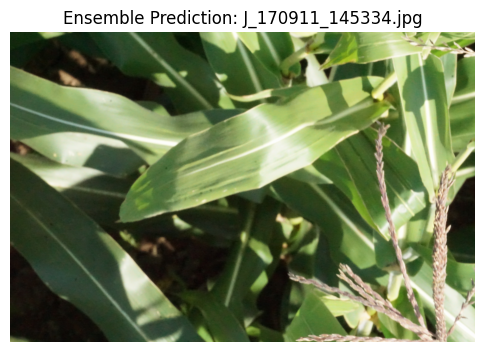

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


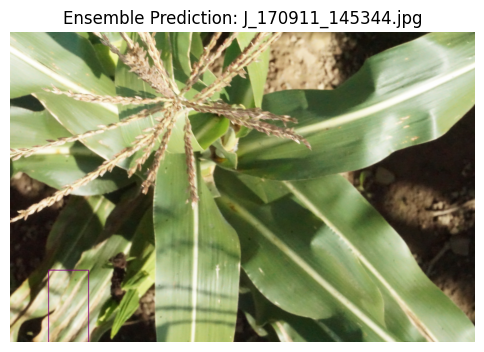

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


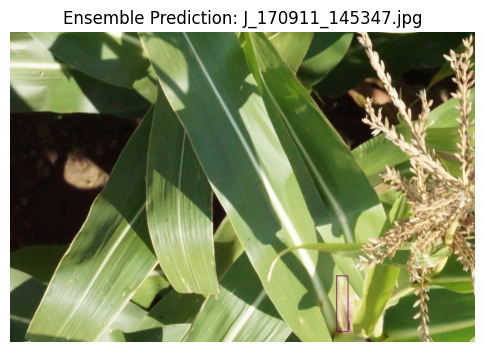

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


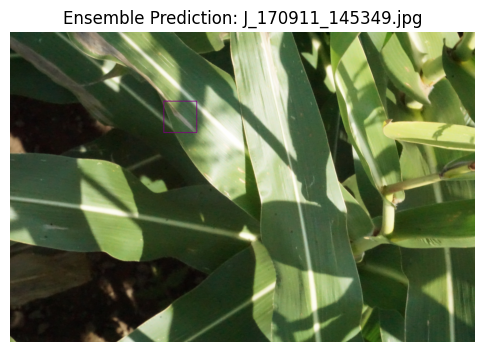

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


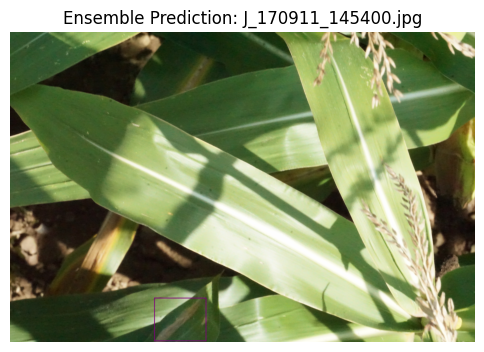

In [52]:
image_batch, original_images, image_paths = load_images_from_folder(test_set_path, num_images=5)
for i in range(len(image_batch)):
    image_array = image_batch[i]
    original_image = original_images[i].copy()
    image_name = os.path.basename(image_paths[i])

    visualize_ensemble_prediction(model_big, model_small, model_general, image_array, original_image, image_name)

In [ ]:
# Assume you have one image already loaded and preprocessed
image_array = image_batch[0]


# Visualize feature maps
visualize_feature_maps(model_big, image_array, layer_name="conv2d_5", num_maps=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


C:\Users\samue\AppData\Local\Temp\ipykernel_36736\2636616620.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored_map = cm.get_cmap(cmap)(feature_map_resized)  # RGBA


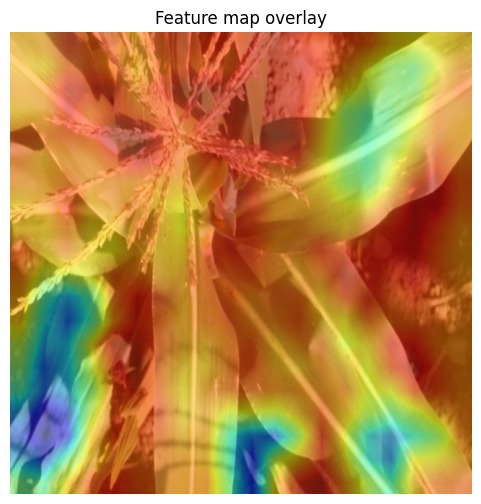

In [ ]:

image_array = image_batch[1] 

intermediate_model = tf.keras.Model(inputs=model_general.input,
                                    outputs=model_general.get_layer("conv2d_18").output)
feature_maps = intermediate_model.predict(np.expand_dims(image_array, axis=0))  # shape: (1, H, W, C)

feature_map = feature_maps[0, :, :, 0]  # for example, the 0th feature map

blended_image = overlay_feature_map_on_image(image_array, feature_map, alpha=0.5)

plt.figure(figsize=(6, 6))
plt.imshow(blended_image)
plt.title("Feature map overlay")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


C:\Users\samue\AppData\Local\Temp\ipykernel_36736\2636616620.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored_map = cm.get_cmap(cmap)(feature_map_resized)  # RGBA


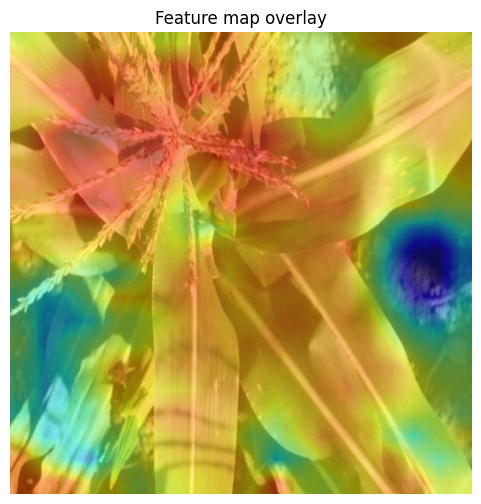

In [75]:
image_array = image_batch[1] 

intermediate_model = tf.keras.Model(inputs=model_big.input,
                                    outputs=model_big.get_layer("conv2d_5").output)
feature_maps = intermediate_model.predict(np.expand_dims(image_array, axis=0))  # shape: (1, H, W, C)

feature_map = feature_maps[0, :, :, 0]  # for example, the 0th feature map

blended_image = overlay_feature_map_on_image(image_array, feature_map, alpha=0.5)

plt.figure(figsize=(6, 6))
plt.imshow(blended_image)
plt.title("Feature map overlay")
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


C:\Users\samue\AppData\Local\Temp\ipykernel_36736\2636616620.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colored_map = cm.get_cmap(cmap)(feature_map_resized)  # RGBA


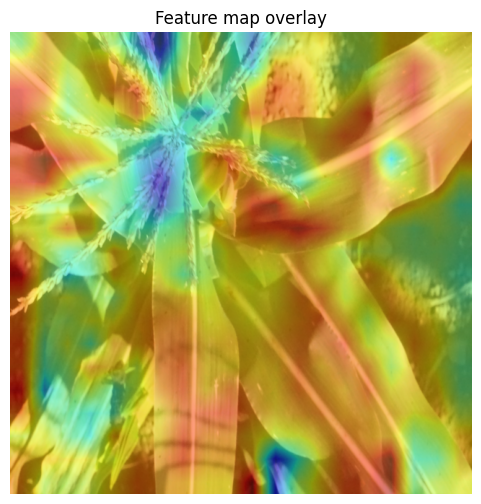

In [76]:
image_array = image_batch[1] 

intermediate_model = tf.keras.Model(inputs=model_small.input,
                                    outputs=model_small.get_layer("conv2d_5").output)
feature_maps = intermediate_model.predict(np.expand_dims(image_array, axis=0))  # shape: (1, H, W, C)

feature_map = feature_maps[0, :, :, 0]  # for example, the 0th feature map

blended_image = overlay_feature_map_on_image(image_array, feature_map, alpha=0.5)

plt.figure(figsize=(6, 6))
plt.imshow(blended_image)
plt.title("Feature map overlay")
plt.axis("off")
plt.show()